# House price example

In [1]:
import dp4gp_datasets as datasets
import dp4gp
import GPy

import pandas as pd
import dp4gp_datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import dp4gp


warning in stationary: failed to import cython module: falling back to numpy


In [44]:
complete = datasets.load_prices_and_postcode()
ys = complete['price'].values
training_inputs = np.vstack([complete['easting'].values,complete['northing'].values]).T



use_normal = True #whether to use the normal method or inducing input method

#squash data into £200k-£700k range
ys[ys>10e5] = 10e5
ys[ys<1e5] = 1e5
sens = 10e5-1e5

just_london = True

if just_london:
#London
    london_east = 530000
    london_north = 180000
    size = 50000
    
    samp = (training_inputs[:,0]>london_east-size) & (training_inputs[:,0]<london_east+size) & (training_inputs[:,1]>london_north-size) & (training_inputs[:,1]<london_north+size)
    ys = ys[samp]
    training_inputs = training_inputs[samp,:]
else:
    #Most of England
    london_east = 430000
    london_north = 250000
    size = 250000



#reduce training size if too big
import random
samp = random.sample(range(1, len(ys)), 2000)
ys = ys[samp]

training_inputs = training_inputs[samp,:]

In [45]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=17).fit(training_inputs) #50 cities, so using about 70 inducing inputs. just london - use 10

centres = kmeans.cluster_centers_
sparse = []
for i, c in enumerate(centres):
    skip = False
    for d in centres[0:i]:
        if (np.sum((d-c)**2)<5000**2):
            skip = True
            break
    if not skip:
        sparse.append(c)
sparse = np.array(sparse)

In [46]:
test_inputs = []
step = size/15
for easting in np.arange(london_east-size,london_east+size,step):
    for northing in np.arange(london_north-size,london_north+size,step):
        test_inputs.append([easting,northing])
    
test_inputs = np.array(test_inputs)

In [47]:
pseudo_inputs = sparse
if just_london:
    lengthscales = 10000.0
else:
    lengthscales = 50000.0
sigma = np.ones_like(ys) * sens * 0.1
test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo = dp4gp.get_noise_scale(ys,test_inputs,training_inputs,pseudo_inputs,lengthscales,sigma,calc_normal=use_normal)

Calculating covariance between test inputs
Calculating covariance between training inputs and test inputs
Calculating K_NM
Calculating K_MM
Calculating K_NN diagonals
Calculating K_star
Calculating K_NN
Calculating lambda


5.64929710265
3.76448577938
0.566353185538
0.0519923404201


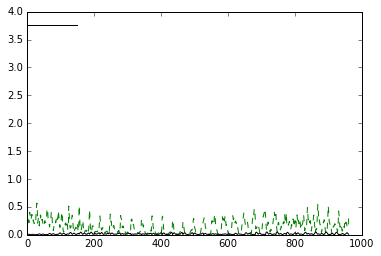

In [48]:
if normal_msense is not None: 
    print normal_msense
print pseudo_msense
if normal_peroutput_msense is not None: 
    print np.max(normal_peroutput_msense)
print np.max(pseudo_peroutput_msense)

if normal_peroutput_msense is not None: 
    plt.plot(normal_peroutput_msense,'g--')
plt.plot(pseudo_peroutput_msense,'k-')
plt.plot([0,150],[pseudo_msense,pseudo_msense],'k-')
#if normal_msense is not None: 
    #plt.plot([0,150],[normal_msense,normal_msense],'g--')

In [49]:
if use_normal:
    msense = normal_peroutput_msense
else:
    msense = pseudo_peroutput_msense
preds = dp4gp.draw_sample(test_cov, test_inputs, pseudo_mu, msense, sens=sens, delta=0.01, eps=5.0)

if use_normal:
    noise_scale = normal_peroutput_msense/np.max(normal_peroutput_msense)        
else:
    noise_scale = pseudo_peroutput_msense/np.max(pseudo_peroutput_msense)

    

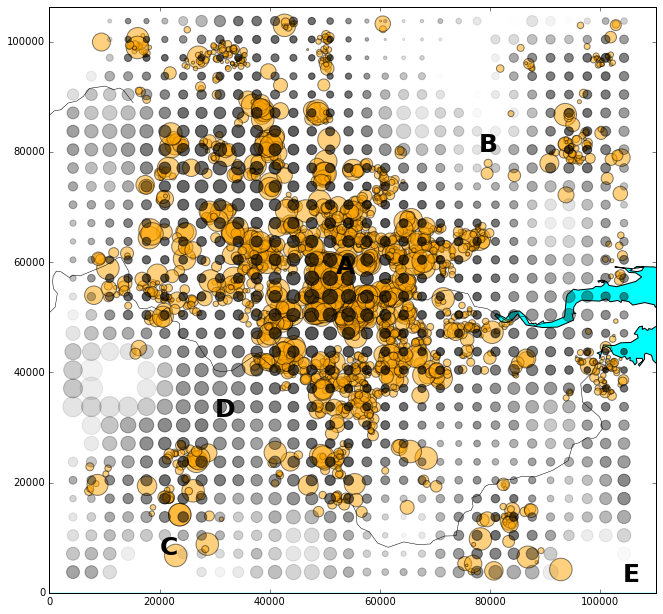

In [50]:
from mpl_toolkits.basemap import Basemap
import mpl_toolkits.basemap.pyproj as pyproj
import matplotlib.pyplot as plt
%matplotlib inline

osgb36=pyproj.Proj("+init=EPSG:27700") # UK Ordnance Survey, 1936 datum
trainlats,trainlongs = osgb36(training_inputs[:,0],training_inputs[:,1],inverse=True)
testlats,testlongs = osgb36(test_inputs[:,0],test_inputs[:,1],inverse=True)
sparselats,sparselongs = osgb36(sparse[:,0],sparse[:,1],inverse=True)

if just_london:
    m = Basemap(llcrnrlon=-0.92,llcrnrlat=51.03,urcrnrlon=0.705,urcrnrlat=51.96,
            resolution='h',projection='tmerc',lon_0=-2,lat_0=49,suppress_ticks=False)
else:
    m = Basemap(llcrnrlon=-5.3,llcrnrlat=49.7,urcrnrlon=2.65,urcrnrlat=54.5,
            resolution='i',projection='tmerc',lon_0=-2,lat_0=49)#,suppress_ticks=False)

m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='white',lake_color='aqua',zorder=0)
m.drawrivers()
#m.drawcounties()

#for x,y in zip(xs,ys):
#    plt.plot(x,y,'x')

if just_london:
    scale = 22000
else:
    scale = 15000


m.scatter(trainlats,trainlongs,(ys/scale)**2,latlon=True,marker='.',alpha=0.5, color='orange',edgecolors='black')
rgbacolours = np.zeros([len(preds),4])
rgbacolours[:,3] = 0.7-noise_scale
rgbacolours[rgbacolours[:,3]<0] = 0
#crosses = rgbacolours.copy()
#crosses[:,3] = 1-crosses[:,3]
#crosses[crosses[:,3]<1,3] = 0
#crosses[:,3] *= 0.5 
#m.scatter(testlats,testlongs,(preds-0)/500,latlon=True,marker='.',color=rgbacolours)
m.scatter(testlats,testlongs,(preds/scale)**2,latlon=True,marker='.',color=rgbacolours)
#m.scatter(testlats,testlongs,50,latlon=True,marker='x',color=crosses)

if not use_normal:
    m.scatter(sparselats,sparselongs,100,marker='x',latlon=True)


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#plt.show()
if just_london:
    plt.text(52000,58000,'A',color='black',size=25,weight='bold')
    plt.text(78000,80000,'B',color='black',size=25,weight='bold')    
    plt.text(20000,7000,'C',color='black',size=25,weight='bold')    
    plt.text(30000,32000,'D',color='black',size=25,weight='bold')    
    plt.text(104000,2000,'E',color='black',size=25,weight='bold')    
plt.savefig('london_combined.pdf')

At locations with many nearby training points (A) relatively little DP perturbation is needed, as a single training point's output will have little effect on the posterior mean. In areas with single training points (B), the posterior mean is highly influenced by a single training point. Areas on the edges of training data are also more sensitive (C) as training points on the edge can have a large effect on how the posterior mean 'leaves' the cluster. This doesn't hold where there's 'support' for the mean from two clusters on either side of the test point (D). Finally we notice that there's little noise added when far from any training points (E). This is because the GP will return to the prior mean, and no training points will have any effect on the estimate here.

### Numerical comparison

Sample at each training point (not we don't leave one out, we are leaving in the training data)

In [9]:
pseudo_inputs = sparse
new_test_inputs = training_inputs[0:1000,:]
#lengthscales = 2000.0

test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo = dp4gp.get_noise_scale(ys,new_test_inputs,training_inputs,pseudo_inputs,lengthscales,sigma,calc_normal=use_normal)  

Calculating covariance between test inputs
Calculating covariance between training inputs and test inputs
Calculating K_NM
Calculating K_MM
Calculating K_NN diagonals
Calculating K_star
Calculating K_NN
Calculating lambda


Draw a sample...

In [10]:
if use_normal:
    preds = dp4gp.draw_sample(test_cov, new_test_inputs, normal_mu, normal_peroutput_msense, sens=sens, delta=0.01, eps=5.0)
else:
    preds = dp4gp.draw_sample(test_cov, new_test_inputs, pseudo_mu, pseudo_peroutput_msense, sens=sens, delta=0.01, eps=5.0)

(0, 800000.0)

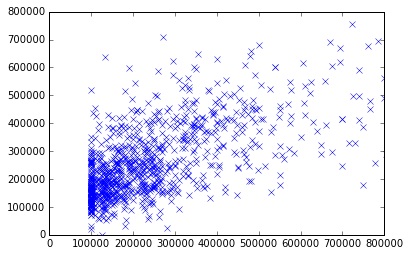

In [11]:
plt.plot(ys[0:1000],preds,'x')
plt.xlim([0,0.8e6])
plt.ylim([0,0.8e6])

# Slice through the country...

In [ ]:
sliceNorthing = 200000
sliceWidth = 2000
inSlice = (complete['northing']>sliceNorthing-sliceWidth) & (complete['northing']<sliceNorthing+sliceWidth)
housesInSlice = complete[inSlice]
#for e,n,p in zip(housesInSlice['easting'],housesInSlice['northing'],housesInSlice['price']):
#    plt.plot(e,n,'ok',markersize=p/1e5,alpha=0.4)

plt.plot(housesInSlice['easting'],np.log(housesInSlice['price']),'o',alpha=0.34)


In [ ]:
plt.figure(figsize=(20,10))
plt.plot(complete['northing'],complete['price'],'ko',markersize=1,alpha=0.05)
plt.ylim([0,1e6])


In [ ]:
for e,n,p in zip(complete['easting'],complete['northing'],complete['price']):
    plt.plot(e,n,'ok',markersize=p/1e5,alpha=0.4)

In [ ]:
len(complete)